# Changes in the stationary state due to varying initial conditions
This notebook aims to study how initial conditions affect the stationary state of the system. For clarity, the coordinates of the initial condition relative to each state variable are not changed simultaneously. This approach allows one to observe how the stationary configuration varies when initial conditions are varied continuously. In this notebook only the homogeneous scenario (without diffusion) is considered; evolution functions are modified consequently.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import configparser
import pandas as pd
import os
from functools import partial 
from scipy.integrate import solve_ivp

### Function to retrieve information from the configuration file

In [2]:
def extract_values(section_name, config):
    values = []
    if section_name in config:
        for key, value in config[section_name].items():
            values.append(float(value))
    else:
        print(f'Section "{section_name}" is not in the configuration file')
    return values

### One-step update in the system's evolution
Both the autonomous and non-autonomous systems are implemented.

In [3]:
#Non autonomous
def one_step(t, dt, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, H_i, C_i, M_i, par):

    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = par

    for i in range(len(H)):

        ev_H(i, dt, d_H, k1, H_i, H, M, D, H_new)
        ev_C(i, dt, d_C, k2, C_i, C, H, D, C_new)
        ev_M(i, dt, d_M, k3, M_i, M, D, M_new)
        ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new)
        ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new)
        R_new[i] = 100 - N_new[i] - D_new[i]

#Autonomous
def one_step_autonomous(dt, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, H_i, C_i, M_i, par):

    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = par

    for i in range(len(H)):

        ev_H(i, dt, d_H, k1, H_i, H, M, D, H_new)
        ev_C(i, dt, d_C, k2, C_i, C, H, D, C_new)
        ev_M(i, dt, d_M, k3, M_i, M, D, M_new)
        ev_N_autonomous(i, dt, k4, k5, R, C, N, N_new)
        ev_D_autonomous(i, dt, d_D, k5, k6, C, M, N, D, D_new)
        R_new[i] = 100  - N_new[i] - D_new[i]


### Original system of differential equations
The following cell is only for the Runge-Kutta implementation.

In [4]:
#System
def DMD_model(t, state_variables, initial_conditions, parameters):

    H, C, M, N, D, R = state_variables
    H_i, C_i, M_i, N_i, D_i, R_i = initial_conditions
    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = parameters
    
    dHdt=eq_H(H, M, D, H_i, k1, d_H)
    dCdt=eq_C(H, C, D, C_i, k2, d_C)
    dMdt=eq_M(M, D, M_i, k3, d_M)
    dNdt=eq_N(t, C, N, R, R_i, k4, k5, sigma, m, h)
    dDdt=eq_D(t, C, M, N, D, D_i, k5, k6, d_D, sigma, m, h)
    dRdt=eq_R(M, D, R, R_i, k4, k6, d_D)

    return [dHdt, dCdt, dMdt, dNdt, dDdt, dRdt]

#Equations
def eq_H(H, M, D, H_i, k1, d_H):
    b_H = d_H * H_i 
    return b_H + k1 * M * D - d_H * H

def eq_C(H, C, D, C_i, k2, d_C):
    b_C = d_C * C_i
    return b_C + k2 * H * D - d_C * C

def eq_M(M, D, M_i, k3, d_M):
    b_M = d_M * M_i
    return b_M + k3 * M * D - d_M * M

def eq_N(t, C, N, R, R_i, k4, k5, sigma, m, h):
    return k4 * R - k5 * C * N - damage(t, sigma, m, h) * N

def eq_D(t, C, M, N, D, D_i, k5, k6, d_D, sigma, m, h):
    return k5 * C * N + damage(t, sigma, m, h) * N - k6 * D * M - d_D * D

def eq_R( M, D, R, R_i, k4, k6, d_D):
    return k6 * D * M + d_D * D - k4 * R  

### Damage function

In [5]:
def damage(t, sigma, m, h):

    if t==0 or t <=1e-14:
        return 0.
    else:
       return h / (t * sigma * np.sqrt(2*np.pi)) * np.exp(-(np.log(t) - m)**2 / (2. * sigma**2))

### Evolution of the immune cells

In [6]:
def ev_H(i, dt, d_H, k1, H_i, H, M, D, H_new):
    
    if i==0:
        H_new[i] = H[i] + dt * (k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
    elif i==len(H)-1:
        H_new[i] = H[i] + dt * (k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
    else:
        H_new[i] = H[i] + dt * (k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))

def ev_C(i, dt, d_C, k2, C_i, C, H, D, C_new):
    
    if i==0:
        C_new[i] = C[i] + dt * (k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
    elif i==N_cells-1:
        C_new[i] = C[i] + dt * (k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
    else:
        C_new[i] = C[i] + dt * (k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
   
def ev_M(i, dt, d_M, k3, M_i, M, D, M_new):
    
    if i==0:
        M_new[i] = M[i] + dt * (k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
    elif i==len(M)-1:
        M_new[i] = M[i] + dt * (k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
    else:
        M_new[i] = M[i] + dt * (k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
        

### Evolution of the composition of muscle tissue

In [7]:
def ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new):
    N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * (k5 * C[i] + damage(t, sigma, m, h)))
    
def ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new):
    D_new[i] = D[i] + dt * (N[i] * (k5 * C[i] + damage(t, sigma, m, h)) - D[i] * (k6 * M[i] + d_D))

def ev_N_autonomous(i, dt, k4, k5, R, C, N, N_new):
    N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * k5 * C[i])
        
def ev_D_autonomous(i, dt, d_D, k5, k6, C, M, N, D, D_new):
    D_new[i] = D[i] + dt * (N[i] * k5 * C[i] - D[i] * (k6 * M[i] + d_D))
        
def ev_R(i, dt, d_D, k4, k6, M, D, R, R_new):
    R_new[i] = R[i] + dt * (D[i] * (k6 * M[i] + d_D) - k4 * R[i])

### Save the output to a .csv file

In [8]:
def save_to_csv(output_list, column_name, directory, file_name):
    os.makedirs(directory, exist_ok=True)
    
    file_path = os.path.join(directory, file_name)
    
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        df = pd.DataFrame()

    df[column_name] = output_list
    
    df.to_csv(file_path, index=False)

### Define which kind of state variable one is working with (tissue or immune cells)
This function recognises whether or not the given variable is a type of fibre in muscle tissue.

In [9]:
def is_muscle_tissue(var):
    if var in ['N', 'D', 'R']:
        return True
    else:
        return False

### Simulation
This simulation illustrates how the system's configuration at t_m and t_e changes when the initial value of one of the state variables is altered (while keeping the other initial conditions as recommended in the reference paper). Both t_m and t_e should be chosen to be large enough for the system to be considered close to a stationary state. Plotting the configuration at two different time steps ensures that the system has indeed converged to a fixed point if the values of each state variable are the same at t_m and t_e.
Initially, the bounds are set approximately to the minimum and maximum values each variable reaches in the reference simulation. Later, different bounds can be selected to focus on specific regions of interest.
By choosing the boolean values of the variables EULER and RUNGE_KUTTA, one can decide whether the integration will be carried out using the first method, the second or both.

In [165]:
RUNGE_KUTTA = True
EULER = True

#Extract the needed parameters from the configuration file
config = configparser.ConfigParser()
config.read('config.ini')

#Parameters and initial conditions
par = extract_values('parameters', config)
i_c = np.array(extract_values('initial_conditions', config))
i_c_stored = i_c.copy() #keeps track of the initial condition in config.ini
sim = extract_values('simulation_par', config)
dt, t_b, t_m, t_e, N_cells = sim
N_cells = int(N_cells)
time = t_b

if RUNGE_KUTTA:
    tolerance_RK = extract_values('runge_kutta', config)
    relative_tol, absolute_tol = tolerance_RK
    
    t_span_1 = (0, t_m)
    t_span_2 = (0, t_e)
    
    t_eval_1 = np.linspace(0, t_m, 1000)
    t_eval_2 = np.linspace(0, t_e, 1000)

'''The broader values from the paper are as follows, but they can be adjusted to focus on a region of particular interest'''
bounds = [(0, 4500), (0, 450), (0, 100000), (0, 100), (0, 100), (0, 100)]
num_samples = [101, 101, 101, 101, 101, 101]
var = 'H'
is_percentage = is_muscle_tissue(var)

n_vars = 6
labels = ['CD4_T_cells', 'CD8_T_cells', 'macrophages', 'normal_fibres', 'damaged_fibres', 'regenerating_fibres']
var_map = {
    'H': 0,
    'C': 1,
    'M': 2,
    'N': 3, 
    'D': 4, 
    'R': 5
}

#State variables and initialisation
H, C, M, N, D, R = [[i_c[k]] * N_cells for k in range(n_vars)]
H_i, C_i, M_i, N_i, D_i, R_i = [[i_c[k]] * N_cells for k in range(n_vars)]
H_new, C_new, M_new, N_new, D_new, R_new = [[i_c[k]] * N_cells for k in range(n_vars)]

#Evolution from t_b to t_e of the model initialised as suggested in the reference paper
time_steps = np.linspace(t_b, t_e, int((t_e - t_b) / dt) + 1)
#Insert t_m if it is not included in time_steps
time_steps = time_steps.tolist() #convert to list
if t_m not in time_steps:
    lower_index = max(i for i in range(len(time_steps)) if time_steps[i] < t_m)
    upper_index = min(i for i in range(len(time_steps)) if time_steps[i] > t_m)
    time_steps.insert(upper_index, t_m)
    
for j in time_steps:
        
        one_step(time, dt, H, C, M, N, D, R, 
                 H_new, C_new, M_new, N_new, D_new, R_new, 
                 H_i, C_i, M_i, par)
        
        H, C, M, N, D, R = H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()
        time = round(time + dt, 2)

#Store the output of the evolution (the second cell is selected, but all cells display the same behaviour)
original_model = [] 
original_model.append([float(H_new[1]), float(C_new[1]), float(M_new[1]), float(N_new[1]), float(D_new[1]), float(R_new[1])])

#Sample the chosen state variable in the predefined bounds
sample = np.linspace(*bounds[var_map[var]], num_samples[var_map[var]])

remaining_vars = []    
for choice in var_map.keys():
    if choice != var:
        remaining_vars.append(choice)

if EULER:
    stationary_t_m, stationary_t_e = [], []
if RUNGE_KUTTA:
    stationary_t_m_RK, stationary_t_e_RK = [], []
i_c_second, i_c_third = [], []

for i in range(num_samples[var_map[var]]):
#At each iteration, the system is reset to its original state and the initial condition is then updated
    i_c = i_c_stored.copy()
    i_c[var_map[var]] = sample[i]

    '''Mass conservation must be maintained in the initial conditions, \
so if N_i, D_i or R_i are changed, the others must be adjusted accordingly'''
    if is_percentage:
        second, third = remaining_vars[3:5] #the last two variables are the ones referring to muscle tissue
        if 100 - i_c[var_map[var]] - i_c[var_map[second]] >= 0:
            i_c[var_map[third]] = 100. - i_c[var_map[var]] - i_c[var_map[second]]
            i_c_second.append(i_c[var_map[second]])
            i_c_third.append(i_c[var_map[third]])
        elif 100 - i_c[var_map[var]] - i_c[var_map[third]] >= 0:
            i_c[var_map[second]] = 100. - i_c[var_map[var]] - i_c[var_map[third]]
            i_c_second.append(i_c[var_map[second]])
            i_c_third.append(i_c[var_map[third]])
        else:
            i_c[var_map[second]] = 100. - i_c[var_map[var]]
            i_c[var_map[third]] = 0.
            i_c_second.append(i_c[var_map[second]])
            i_c_third.append(i_c[var_map[third]])

    if EULER:
        H, C, M, N, D, R = [[i_c[k]] * N_cells for k in range(n_vars)]
        H_i, C_i, M_i, N_i, D_i, R_i = [[i_c[k]] * N_cells for k in range(n_vars)]
        H_new, C_new, M_new, N_new, D_new, R_new = [[i_c[k]] * N_cells for k in range(n_vars)]
    
        time = t_b
    
        #Print this to keep track of the evolution:
        print(f'H_i = {H_i[0]}, C_i = {C_i[0]}, M_i = {M_i[0]}, N_i = {i_c[3]}, D_i = {i_c[4]}, R_i = {i_c[5]}')
        
        for j in time_steps:
            
            one_step(time, dt, H, C, M, N, D, R, 
                     H_new, C_new, M_new, N_new, D_new, R_new, 
                     H_i, C_i, M_i, par)
            
            H, C, M, N, D, R = H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()
            time = round(time + dt, 2)
    
            if j == t_m:
                stationary_t_m.append([float(H_new[1]), float(C_new[1]), float(M_new[1]), float(N_new[1]), float(D_new[1]), float(R_new[1])])
            elif j == t_e:   
                stationary_t_e.append([float(H_new[1]), float(C_new[1]), float(M_new[1]), float(N_new[1]), float(D_new[1]), float(R_new[1])])
    
    if RUNGE_KUTTA:
        DMD_model_ic = partial(DMD_model, initial_conditions = i_c, parameters=par)

        solution_1 = solve_ivp(DMD_model_ic,
                               t_span_1,
                               i_c,
                               method='RK45',
                               t_eval=t_eval_1,
                               rtol=relative_tol,
                               atol=absolute_tol
                              )
        solution_2 = solve_ivp(DMD_model_ic,
                               t_span_2,
                               i_c,
                               method='RK45',
                               t_eval=t_eval_2,
                               rtol=relative_tol,
                               atol=absolute_tol
                              )
        
        values_1 = solution_1.y
        values_2 = solution_2.y

#Store just the configurations at t_m and t_e
        stationary_t_m_RK.append([values_1[0][-1], values_1[1][-1], values_1[2][-1], values_1[3][-1], values_1[4][-1], values_1[5][-1]])
        stationary_t_e_RK.append([values_2[0][-1], values_2[1][-1], values_2[2][-1], values_2[3][-1], values_2[4][-1], values_2[5][-1]])

directory = f'sample_{var}i/time_{t_m}_{t_e}_dt_{dt}/range_{bounds[var_map[var]][0]}_{bounds[var_map[var]][1]}/'

H_i = 0.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 45.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 90.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 135.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 180.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 225.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 270.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 315.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 360.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 405.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 450.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 495.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 540.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 585.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 630.

/var/folders/fj/xx8_jc2x0nn7wbdtp17njw600000gn/T/ipykernel_63770/2695741851.py:4: RuntimeWarning: overflow encountered in scalar multiply
  H_new[i] = H[i] + dt * (k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
/var/folders/fj/xx8_jc2x0nn7wbdtp17njw600000gn/T/ipykernel_63770/2695741851.py:13: RuntimeWarning: overflow encountered in scalar multiply
  C_new[i] = C[i] + dt * (k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
/var/folders/fj/xx8_jc2x0nn7wbdtp17njw600000gn/T/ipykernel_63770/2695741851.py:22: RuntimeWarning: overflow encountered in scalar multiply
  M_new[i] = M[i] + dt * (k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
/var/folders/fj/xx8_jc2x0nn7wbdtp17njw600000gn/T/ipykernel_63770/1380405635.py:2: RuntimeWarning: overflow encountered in scalar multiply
  N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * (k5 * C[i] + damage(t, sigma, m, h)))
/var/folders/fj/xx8_jc2x0nn7wbdtp17njw600000gn/T/ipykernel_63770/1380405635.py:5: RuntimeWarning: overflow encountered in scalar multiply
  D_new[i] = D[i] + d

H_i = 2340.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 2385.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 2430.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 2475.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 2520.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 2565.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 2610.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 2655.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 2700.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 2745.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 2790.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 2835.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 2880.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_i = 0.0
H_i = 2925.0, C_i = 4.0, M_i = 400.0, N_i = 100.0, D_i = 0.0, R_

Save the output files in .csv format.

In [161]:
#Save as .csv files
if is_percentage:
    save_to_csv(sample, f'{var}i_sample', directory, f'sample_{var}.csv')
    save_to_csv(i_c_second, f'{remaining_vars[-2]}i', directory, f'sample_{var}.csv')
    save_to_csv(i_c_third, f'{remaining_vars[-1]}i', directory, f'sample_{var}.csv')
else:
    save_to_csv(sample, f'{var}_dt_{dt}_sample', directory, f'sample_{var}.csv')

if EULER:
    column = 'euler'

    save_to_csv([row[0] for row in stationary_t_m], column, directory, f'H_{t_m}_weeks.csv')
    save_to_csv([row[0] for row in stationary_t_e], column, directory, f'H_{t_e}_weeks.csv')
    save_to_csv([row[1] for row in stationary_t_m], column, directory, f'C_{t_m}_weeks.csv')
    save_to_csv([row[1] for row in stationary_t_e], column, directory, f'C_{t_e}_weeks.csv')
    save_to_csv([row[2] for row in stationary_t_m], column, directory, f'M_{t_m}_weeks.csv')
    save_to_csv([row[2] for row in stationary_t_e], column, directory, f'M_{t_e}_weeks.csv')
    save_to_csv([row[3] for row in stationary_t_m], column, directory, f'N_{t_m}_weeks.csv')
    save_to_csv([row[3] for row in stationary_t_e], column, directory, f'N_{t_e}_weeks.csv')
    save_to_csv([row[4] for row in stationary_t_m], column, directory, f'D_{t_m}_weeks.csv')
    save_to_csv([row[4] for row in stationary_t_e], column, directory, f'D_{t_e}_weeks.csv')
    save_to_csv([row[5] for row in stationary_t_m], column, directory, f'R_{t_m}_weeks.csv')
    save_to_csv([row[5] for row in stationary_t_e], column, directory, f'R_{t_e}_weeks.csv')

if RUNGE_KUTTA:
    column = f'RK_rtol_{relative_tol}_atol_{absolute_tol}'
    
    save_to_csv([row[0] for row in stationary_t_m_RK], column, directory, f'H_{t_m}_weeks.csv')
    save_to_csv([row[0] for row in stationary_t_e_RK], column, directory, f'H_{t_e}_weeks.csv')
    save_to_csv([row[1] for row in stationary_t_m_RK], column, directory, f'C_{t_m}_weeks.csv')
    save_to_csv([row[1] for row in stationary_t_e_RK], column, directory, f'C_{t_e}_weeks.csv')
    save_to_csv([row[2] for row in stationary_t_m_RK], column, directory, f'M_{t_m}_weeks.csv')
    save_to_csv([row[2] for row in stationary_t_e_RK], column, directory, f'M_{t_e}_weeks.csv')
    save_to_csv([row[3] for row in stationary_t_m_RK], column, directory, f'N_{t_m}_weeks.csv')
    save_to_csv([row[3] for row in stationary_t_e_RK], column, directory, f'N_{t_e}_weeks.csv')
    save_to_csv([row[4] for row in stationary_t_m_RK], column, directory, f'D_{t_m}_weeks.csv')
    save_to_csv([row[4] for row in stationary_t_e_RK], column, directory, f'D_{t_e}_weeks.csv')
    save_to_csv([row[5] for row in stationary_t_m_RK], column, directory, f'R_{t_m}_weeks.csv')
    save_to_csv([row[5] for row in stationary_t_e_RK], column, directory, f'R_{t_e}_weeks.csv')

Plot the output of the simulation.

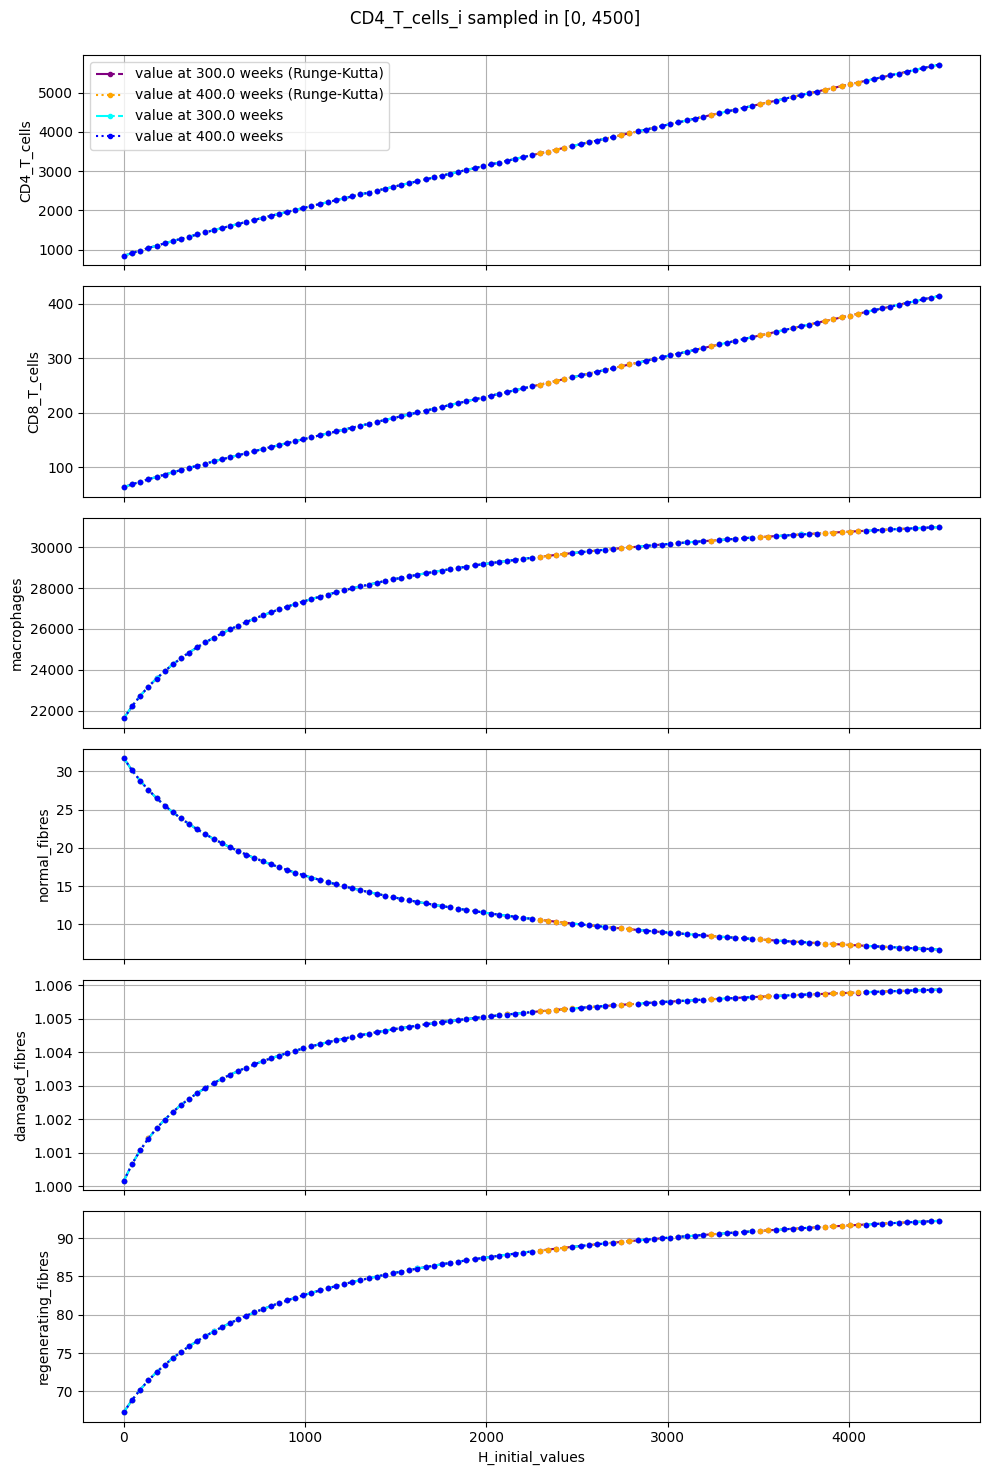

In [166]:
fig, axes = plt.subplots(n_vars, 1, figsize=(10, 15), sharex=True)

for i in range(n_vars):
    if RUNGE_KUTTA:
        axes[i].plot(sample, [row[i] for row in stationary_t_m_RK], label=f'value at {t_m} weeks (Runge-Kutta)', color='purple', linestyle='-.', marker='.')
        #axes[i].scatter(sample, [row[i] for row in stationary_t_m_RK], label=f'value at {t_m} weeks (Runge-Kutta)', color='purple', marker='.')
        axes[i].plot(sample, [row[i] for row in stationary_t_e_RK], label=f'value at {t_e} weeks (Runge-Kutta)', color='orange', linestyle=':', marker='.')
        #axes[i].scatter(sample, [row[i] for row in stationary_t_e_RK], label=f'value at {t_e} weeks (Runge-Kutta)', color='orange', marker='.')
    if EULER:
        axes[i].plot(sample, [row[i] for row in stationary_t_m], label=f'value at {t_m} weeks', color='cyan', linestyle='-.', marker='.')
        #axes[i].scatter(sample, [row[i] for row in stationary_t_m], label=f'value at {t_m} weeks', color='cyan', marker='.')
        axes[i].plot(sample, [row[i] for row in stationary_t_e], label=f'value at {t_e} weeks', color='blue', linestyle=':', marker='.')
        #axes[i].scatter(sample, [row[i] for row in stationary_t_e], label=f'value at {t_e} weeks', color='blue', marker='.')
        #axes[i].scatter(i_c_stored[var_map[var]], original_model[0][i], color='blue', label=f'value at {t_e} weeks with {var}_i = {i_c_stored[var_map[var]]}', marker='x')
        
    axes[i].set_ylabel(labels[i])
    axes[i].grid(True)

axes[-1].set_xlabel(f'{var}_initial_values')
axes[0].legend(loc='best')

fig.suptitle(f'{labels[var_map[var]]}_i sampled in [{bounds[var_map[var]][0]}, {bounds[var_map[var]][1]}]')

plt.tight_layout()
plt.subplots_adjust(top=0.95)

if EULER and not RUNGE_KUTTA:
    filename = (
        f'{num_samples[var_map[var]]}_samples'
        f'_euler.png'
    )

    filepath = directory + filename

elif EULER and RUNGE_KUTTA:
    filename = (
        f'{num_samples[var_map[var]]}_samples'
        f'_euler&RK'
        f'_rtol_{relative_tol}'
        f'_atol_{absolute_tol}.png'
    )

    filepath = directory + filename
    
elif not EULER and RUNGE_KUTTA:
    filename = (
        f'{num_samples[var_map[var]]}_samples'
        f'_RK'
        f'_rtol_{relative_tol}'
        f'_atol_{absolute_tol}.png'
    )

    filepath = directory + filename

#plt.savefig(filepath)
plt.show()

This cell can plot the results of previous simulations saved in the .csv files. This is useful for adjusting the plots’ appearance without having to re-run the entire simulation. Be sure to set the initial parameters correctly at the beginning of the cell, in accordance with the output stored in the .csv files. By setting the variables EULER and RUNGE_KUTTA to either True or False, you can choose which results to display.

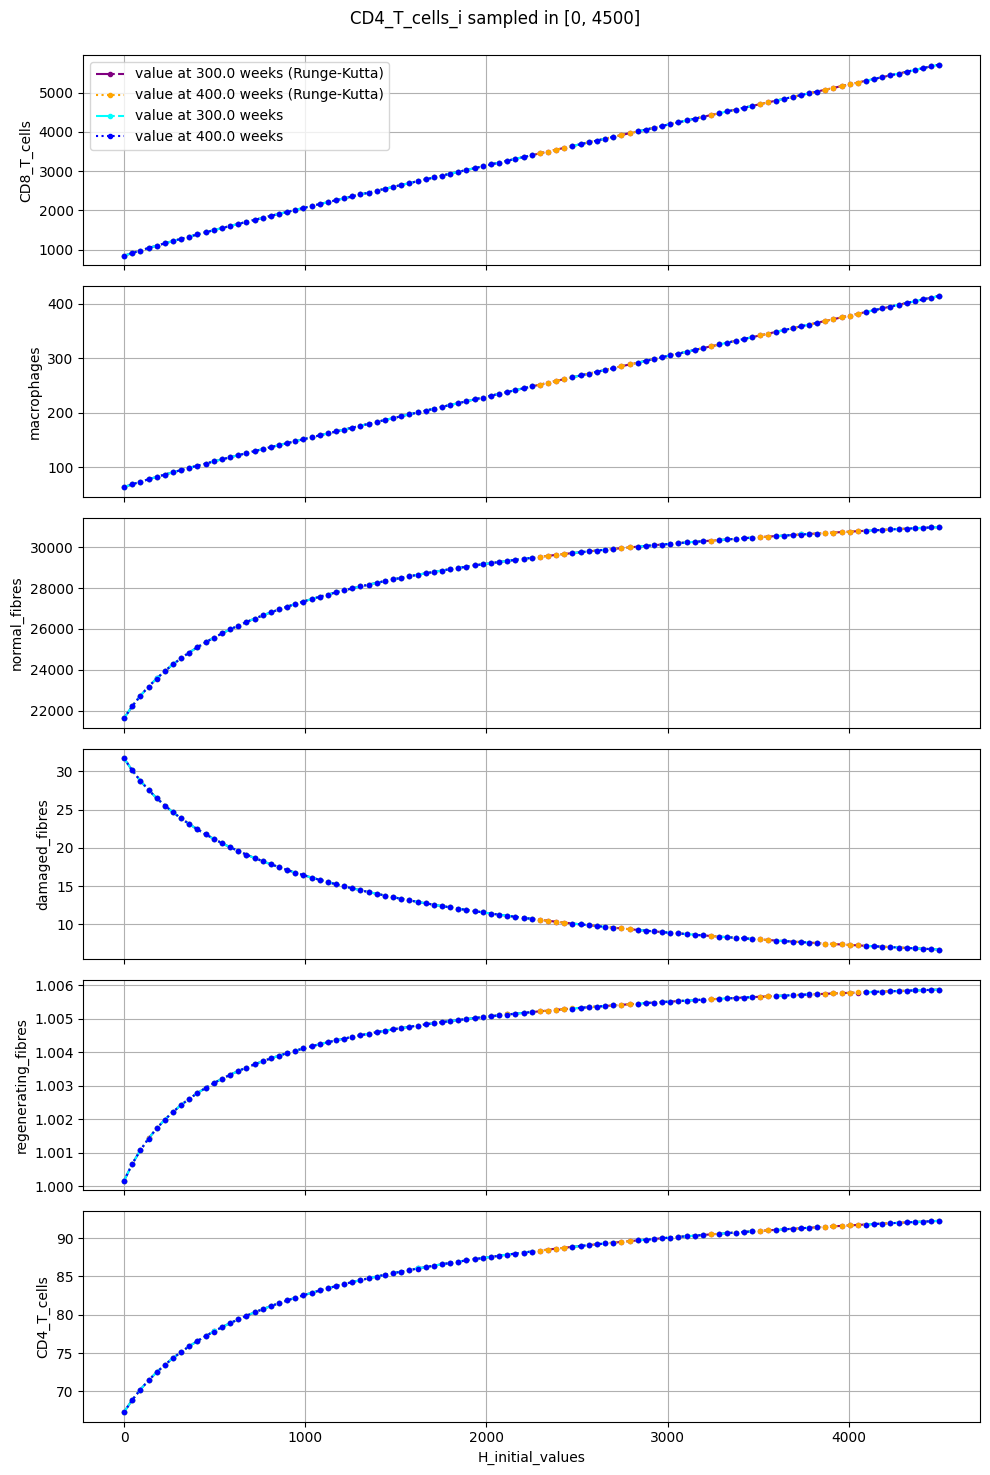

In [179]:
EULER = True
RUNGE_KUTTA = True

i_c = i_c_stored.copy()
#Parameters
bounds = [(0, 4500), (0, 450), (0, 100000), (0, 100), (0, 100), (0, 100)] #original bounds
num_samples = [101, 101, 101, 101, 101, 101]
var = 'H'
t_m = 300.
t_e = 400.
dt = 0.05
relative_tol = 1e-6
absolute_tol = 1e-9

###Evolution from t_b to t_e of the model initialised as suggested in the reference paper

#H, C, M, N, D, R = [[i_c[k]] * N_cells for k in range(n_vars)]
#H_i, C_i, M_i, N_i, D_i, R_i = [[i_c[k]] * N_cells for k in range(n_vars)]
#H_new, C_new, M_new, N_new, D_new, R_new = [[i_c[k]] * N_cells for k in range(n_vars)]

#time_steps = np.linspace(t_b, t_e, int((t_e - t_b) / dt) + 1)
#for j in time_steps:
        
 #       one_step(time, dt, H, C, M, N, D, R, 
  #               H_new, C_new, M_new, N_new, D_new, R_new, 
   #              H_i, C_i, M_i, par)
        
    #    H, C, M, N, D, R = H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()
     #   time = round(time + dt, 2)

#Store the output of the evolution (the second cell is selected, but all cells display the same evolution)
#paper_model = [] 
#paper_model.append([float(H_new[1]), float(C_new[1]), float(M_new[1]), float(N_new[1]), float(D_new[1]), float(R_new[1])])

directory_path = f'sample_{var}i/time_{t_m}_{t_e}_dt_{dt}/range_{bounds[var_map[var]][0]}_{bounds[var_map[var]][1]}/'

#x-axis values
sample_df = pd.read_csv(os.path.join(directory_path, f'sample_{var}.csv'))
samples = sample_df.iloc[:, 0]  # Assuming the first (or only) column contains x-values

#y-axis values
H_df = pd.read_csv(os.path.join(directory_path, f'H_{t_m}_weeks.csv'))
C_df = pd.read_csv(os.path.join(directory_path, f'C_{t_m}_weeks.csv'))
M_df = pd.read_csv(os.path.join(directory_path, f'M_{t_m}_weeks.csv'))
N_df = pd.read_csv(os.path.join(directory_path, f'N_{t_m}_weeks.csv'))
D_df = pd.read_csv(os.path.join(directory_path, f'D_{t_m}_weeks.csv'))
R_df = pd.read_csv(os.path.join(directory_path, f'R_{t_m}_weeks.csv'))

if EULER:
    column = 'euler'
    
    H_values_1 = H_df[column]
    C_values_1 = C_df[column]
    M_values_1 = M_df[column]
    N_values_1 = N_df[column]
    D_values_1 = D_df[column]
    R_values_1 = R_df[column]
    checkpoint_1 = [H_values_1, C_values_1, M_values_1, N_values_1, D_values_1, R_values_1]
    
if RUNGE_KUTTA:
    column = f'RK_rtol_{relative_tol}_atol_{absolute_tol}'
    
    H_values_1_RK = H_df[column]
    C_values_1_RK = C_df[column] 
    M_values_1_RK = M_df[column] 
    N_values_1_RK = N_df[column] 
    D_values_1_RK = D_df[column] 
    R_values_1_RK = R_df[column] 
    checkpoint_1_RK = [H_values_1_RK, C_values_1_RK, M_values_1_RK, N_values_1_RK, D_values_1_RK, R_values_1_RK]

H_df = pd.read_csv(os.path.join(directory_path, f'H_{t_e}_weeks.csv'))
C_df = pd.read_csv(os.path.join(directory_path, f'C_{t_e}_weeks.csv'))
M_df = pd.read_csv(os.path.join(directory_path, f'M_{t_e}_weeks.csv'))
N_df = pd.read_csv(os.path.join(directory_path, f'N_{t_e}_weeks.csv'))
D_df = pd.read_csv(os.path.join(directory_path, f'D_{t_e}_weeks.csv'))
R_df = pd.read_csv(os.path.join(directory_path, f'R_{t_e}_weeks.csv'))

if EULER:
    column = 'euler'
    
    H_values_2 = H_df[column] 
    C_values_2 = C_df[column] 
    M_values_2 = M_df[column] 
    N_values_2 = N_df[column] 
    D_values_2 = D_df[column] 
    R_values_2 = R_df[column] 
    checkpoint_2 = [H_values_2, C_values_2, M_values_2, N_values_2, D_values_2, R_values_2]

if RUNGE_KUTTA:
    column = f'RK_rtol_{relative_tol}_atol_{absolute_tol}'
    
    H_values_2_RK = H_df[column] 
    C_values_2_RK = C_df[column] 
    M_values_2_RK = M_df[column] 
    N_values_2_RK = N_df[column] 
    D_values_2_RK = D_df[column] 
    R_values_2_RK = R_df[column] 
    checkpoint_2_RK = [H_values_2_RK, C_values_2_RK, M_values_2_RK, N_values_2_RK, D_values_2_RK, R_values_2_RK]
    
#Plot
fig, axes = plt.subplots(n_vars, 1, figsize=(10, 15), sharex=True)

for i in range(n_vars):
    if RUNGE_KUTTA:
        axes[i].plot(samples, checkpoint_1_RK[i], label=f'value at {t_m} weeks (Runge-Kutta)', color='purple', linestyle='-.', marker='.')
        #axes[i].scatter(samples, checkpoint_1_RK[i], label=f'value at {t_m} weeks (Runge-Kutta)', color='purple', marker='.')
        axes[i].plot(samples, checkpoint_2_RK[i], label=f'value at {t_e} weeks (Runge-Kutta)', color='orange', linestyle=':', marker='.')
        #axes[i].scatter(samples, checkpoint_2_RK[i], label=f'value at {t_e} weeks (Runge-Kutta)', color='orange', marker='.')
    if EULER:
        axes[i].plot(samples, checkpoint_1[i], label=f'value at {t_m} weeks', color='cyan', linestyle='-.', marker='.')
        #axes[i].scatter(samples, checkpoint_1[i], label=f'value at {t_m} weeks', color='cyan', marker='.')
        axes[i].plot(samples, checkpoint_2[i], label=f'value at {t_e} weeks', color='blue', linestyle=':', marker='.')
        #axes[i].scatter(samples, checkpoint_2[i], label=f'value at {t_e} weeks', color='blue', marker='.')
        #axes[i].scatter(i_c_stored[var_map[var]], paper_model[0][i], color='blue', label=f'value at {t_e} weeks with {var}_i = {i_c_stored[var_map[var]]}', marker='x')
    
    axes[i].set_ylabel(labels[(i+1)%n_vars])
    axes[i].grid(True)

axes[-1].set_xlabel(f'{var}_initial_values')
axes[0].legend(loc='best')

fig.suptitle(f'{labels[var_map[var]]}_i sampled in [{bounds[var_map[var]][0]}, {bounds[var_map[var]][1]}]')

plt.tight_layout()
plt.subplots_adjust(top=0.95)

if EULER and not RUNGE_KUTTA:
    filename = (
        f'{num_samples[var_map[var]]}_samples'
        f'_euler.png'
    )

    filepath = directory_path + filename

elif EULER and RUNGE_KUTTA:
    #filename = (
     #   f'{num_samples[var_map[var]]}_samples'
      #  f'_euler&RK'
       # f'_rtol_{relative_tol}'
        #f'_atol_{absolute_tol}.png'
    #)

    filename = 'dove_sei.png'

    filepath = directory_path + filename
    
elif not EULER and RUNGE_KUTTA:
    filename = (
        f'{num_samples[var_map[var]]}_samples'
        f'_RK'
        f'_rtol_{relative_tol}'
        f'_atol_{absolute_tol}.png'
    )

    filepath = directory_path + filename

#plt.savefig(filepath)
plt.show()